# Training a CNN in TensorFlow for cloud gap filling

Based on Tylere's tutorial https://github.com/tylere/ee-jupyter-examples/blob/master/4 - Earth Engine and TensorFlow.ipynb

In [1]:
import ee
from IPython import display
import math
import pandas as pd
from matplotlib import pyplot
import numpy as np
# from osgeo import gdal
# import tempfile
import tensorflow as tf
# import urllib
# import zipfile

ee.Initialize()

In [36]:
# Stack exported tifs from GEE into one multiband tif
import rasterio
import os

path = '../data/images/clear_4337_LC08_026038_20160325'

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

file_list = []
for file in listdir_fullpath(path):
    if file.endswith('.tif'):
        file_list.append(file)

feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order

#=========== Want to rearrange the order of files so that target feature is last

# Create list of features with target feature (flooded) last
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Create 1 row df of file names where each col is a feature name, in the order files are stored locally
file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# Then index the file list by the ordered list of feature names used in training
file_arr = file_arr.loc[:, feat_list_new]

# The take this re-ordered row as a list - the new file_list
file_list = list(file_arr.iloc[0,:])
    
# Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# and we are converting the other bands to float64
with rasterio.open(file_list[1]) as src0:
    meta = src0.meta
    meta['dtype'] = 'float32'
#         print(meta)

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer, convert to float, and write it to stack
# There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# Make new directory for stacked tif if it doesn't already exist
try:
    os.mkdir(path+'/stack')
except OSError:
    pass

# Remove stack file if already exists
try:
    os.remove(path + '/stack/stack.tif')
except OSError:
    pass

with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=0):
        with rasterio.open(layer) as src1:
            dst.write_band(id+1, src1.read(1).astype('float32'))


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [37]:
# Preprocess the data

# Get local image
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN

# Convert -999999 to None
data[data == -999999] = np.nan

# Get indices of non-nan values. These are the indices of the original image array
# data_ind = np.where(data[:,:,1] != None)
data_ind = np.where(~np.isnan(data[:,:,1]))
row, col = zip(np.where(~np.isnan(data[:,:,1]))) # image row and col of values
len(*row)


14000674

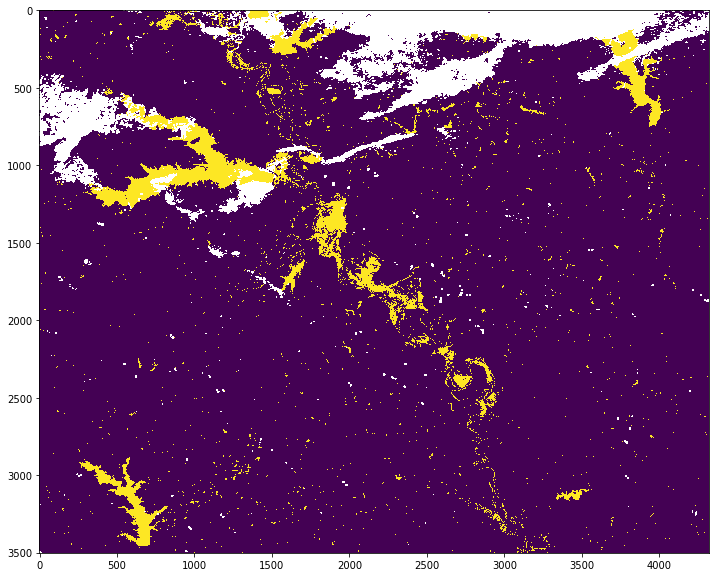

In [33]:
pyplot.figure(figsize = (12,12))
pyplot.imshow(data[:,:,6])
pyplot.show()

In [39]:
HOLDOUT_FRACTION = 0.1

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Remove NaNs
data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
data_vector.shape

# Select only the valid data and shuffle it.
# valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
np.random.shuffle(data_vector)

# Hold out a fraction of the labeled data for validation.
training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
training_data = data_vector[0:training_size,:]
validation_data = data_vector[training_size:-1,:]

# Compute per-band means and standard deviations of the input bands.
data_mean = training_data[:,0:15].mean(0)
data_std = training_data[:,0:15].std(0)

In [58]:
# Build TF model
def make_nn_layer(input, output_size):
  input_size = input.get_shape().as_list()[1]
  weights = tf.Variable(tf.truncated_normal(
      [input_size, output_size],
      stddev=1.0 / math.sqrt(float(input_size))))
  biases = tf.Variable(tf.zeros([output_size]))
  return tf.matmul(input, weights) + biases

In [70]:
# These are all hyperparameters that need to be tuned
NUM_INPUT_BANDS = 15
NUM_HIDDEN_1 = 15
NUM_HIDDEN_2 = 15
NUM_CLASSES = 2

input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS])
labels = tf.placeholder(tf.float32, shape=[None])

normalized = (input - data_mean) / data_std
hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1))
hidden2 = tf.nn.tanh(make_nn_layer(hidden1, NUM_HIDDEN_2))
logits = make_nn_layer(hidden2, NUM_CLASSES)
outputs = tf.argmax(logits, 1)

int_labels = tf.to_int64(labels)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = int_labels, name='xentropy')
train_step = tf.train.AdamOptimizer().minimize(cross_entropy) # should we minimize something else?

correct_prediction = tf.equal(outputs, int_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [91]:
# Train the neural net
# Had to alter some config and runoptions because kept running into OOM at last step during eval 
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)

flooded = feat_list_files.index('flooded')
BATCH_SIZE = 600
NUM_BATCHES = 100

with tf.Session(config=config) as sess:
  sess.run(tf.initialize_all_variables(), options=run_options)

  validation_dict = {
    input: validation_data[:,0:15],
    labels: validation_data[:,14],
  }

  for i in range(NUM_BATCHES):
    batch = training_data[np.random.choice(training_size, BATCH_SIZE, False),:]
    train_step.run({input: batch[:,0:15], labels: batch[:,14]})

    if i % 100 == 0 or i == NUM_BATCHES - 1:
      print('Accuracy %.2f%% at step %d' % (accuracy.eval(validation_dict) * 100, i))

  output_data = outputs.eval({input: data_vector[:,0:15]})

# Accuracy is still low - dataset might be too imbalanced with flooding as a rare event. How to fix that?
# https://datascience.stackexchange.com/questions/30930/accuracy-and-loss-dont-change-in-cnn-is-it-over-fitting

Accuracy 49.05% at step 0
Accuracy 98.45% at step 99


### Test on cloud gaps

In [ ]:
# Stack exported tifs from GEE into one multiband tif
import rasterio
import os

path = '../data/images/clouds_4337_LC08_026038_20160325'

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

file_list = []
for file in listdir_fullpath(path):
    if file.endswith('.tif'):
        file_list.append(file)

feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order

#=========== Want to rearrange the order of files so that target feature is last

# Create list of features with target feature (flooded) last
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Create 1 row df of file names where each col is a feature name, in the order files are stored locally
file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# Then index the file list by the ordered list of feature names used in training
file_arr = file_arr.loc[:, feat_list_new]

# The take this re-ordered row as a list - the new file_list
file_list = list(file_arr.iloc[0,:])
    
# Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# and we are converting the other bands to float64
with rasterio.open(file_list[1]) as src0:
    meta = src0.meta
    meta['dtype'] = 'float32'
#         print(meta)

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer, convert to float, and write it to stack
# There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# Make new directory for stacked tif if it doesn't already exist
try:
    os.mkdir(path+'/stack')
except OSError:
    pass

# Remove stack file if already exists
try:
    os.remove(path + '/stack/stack.tif')
except OSError:
    pass

with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=0):
        with rasterio.open(layer) as src1:
            dst.write_band(id+1, src1.read(1).astype('float32'))


In [ ]:
# Preprocess the data

# Get local image
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN

# Convert -999999 to None
data[data == -999999] = np.nan

# Get indices of non-nan values. These are the indices of the original image array
# data_ind = np.where(data[:,:,1] != None)
data_ind = np.where(~np.isnan(data[:,:,1]))
row, col = zip(np.where(~np.isnan(data[:,:,1]))) # image row and col of values
len(*row)

In [ ]:
HOLDOUT_FRACTION = 0.1

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Remove NaNs
data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
data_vector.shape

# Select only the valid data and shuffle it.
# valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
np.random.shuffle(data_vector)

# Hold out a fraction of the labeled data for validation.
training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
training_data = data_vector[0:training_size,:]
validation_data = data_vector[training_size:-1,:]

# Compute per-band means and standard deviations of the input bands.
data_mean = training_data[:,0:15].mean(0)
data_std = training_data[:,0:15].std(0)

In [78]:
# Inspect results
output_image = output_data.reshape([data.shape[0], data.shape[1]])
red = numpy.where(data[:,:,8], output_image, 0.5)
blue = numpy.where(data[:,:,8], data[:,:,7], 0.5)
green = numpy.minimum(red, blue)

comparison_image = numpy.dstack((red, green, blue))
pyplot.figure(figsize = (12,12))
pyplot.imshow(comparison_image)
pyplot.show()

array([0., 0., 0., ..., 0., 0., 1.], dtype=float32)

In [ ]:
pyplot.figure(figsize = (12,12))
pyplot.imshow(comparison_image[300:500,600:,:], interpolation='nearest')
pyplot.show()